## Introduction

New York City's demographics show that it is a large and ethnically diverse metropolis. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.

This final project explores the best locations for Japanese restaurants throughout the city of New York. As New York is the most diverse city in the world (800 languages are spoken in New York), it has a long tradition of different ethnical restaurants. Now when the idea of a healthy lifestyle conquered the minds of people all over the country, Japanese restaurants became extremely popular, as they offer a healthy alternative to regular American eating habits. That's why Potentially the owner of the new East European restaurant can have great success and consistent profit. However, as with any business, opening a new restaurant requires serious considerations and is more complicated than it seems from the first glance. In particular, the location of the restaurant is one of the most important factors that will affect whether it will have success or a failure. So our project will attempt to answer the questions “Where should the investor open a Japanese Restaurant?” and “Where should I go If I want great Japanese food?”

## Data

In order to answer the above questions, data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

All data related to locations and quality of Italian restaurants will be obtained via the FourSquare API utilized via the Request library in Python.


## Methodology
• Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.

• FourSquare be used to locate all venues and then filtered by Japanese restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.

• Data will be sorted based on rankings.

• Finally, the data be will be visually assessed using graphing from Python libraries.

### Problem Statement
What is / are the best location(s) for Japanese cuisine in New York City?

In what Neighborhood and/or borough should the investor open a Japanese restaurant to have the best chance of being successful?

Where would I go in New York City to have the best Japanese food?

### Before we get the data and start exploring it, let's import all required libraries .


In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1h             |       h516909a_0         2.1 MB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ca-certificates-2020.11.8  |       ha878542_0         145 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    certifi-2020.11.8          |   py36h5fab9bb_0         150 KB  conda-forge
    ------------------------------------------------------------
                       

## My variables¶


In [4]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'LAVSIHUCFLPYNJ0JJOS1SPKPBMRXSISS012QY5B0LZCXDGA0' # your Foursquare ID
CLIENT_SECRET = '3PFAYH1L3SQE2QUVJLVOBKQAIJYELY2H5HJTTO45YYC2WK4N' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

 ### define the functions we are going to use later in this project

In [5]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

## Now let's use the above codes to get our initial NYC data¶


In [6]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
ny_data.shape


(306, 4)

 So there are total of 306 different Neighborhoods in New York.

## Initial Data Analysis¶
Now let's analyze our initial data.

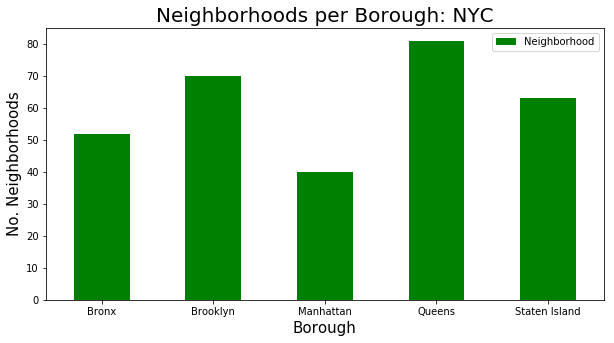

In [8]:
clr = "green"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()


Let's analyze further and see how many Japanese restaurants there are in each neighborhood and borough. After it, graph the results

In [9]:
# queens has most neighborhoods
# prepare neighborhood list that contains japanese restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_restaurants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(ny_data),')','Japanese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(japanese_restaurants)))
    print(row)
    for resturant_detail in japanese_restaurants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Japanese Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Japanese Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Japanese Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Japanese Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Japanese Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Japanese Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Japanese Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Japanese Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Japanese Restaurants in Norwood, B

In [10]:
#japanese_rest_ny.to_csv('japanese_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
japanese_rest_ny.to_csv('japanese_rest_ny_tocsv1.csv')

In [11]:

japanese_ny = pd.read_csv('japanese_rest_ny_tocsv1.csv')
japanese_rest_ny.tail()

,Borough,Neighborhood,ID,Name
62,Manhattan,Flatiron,581a10901df6b32e66ec3a07,Sugarfish
63,Manhattan,Flatiron,55805bb5498e8356d675aa22,Yakiniku Futago
64,Queens,Sunnyside Gardens,4ba2a9cbf964a520d00d38e3,Oki Japanese Restaurant
65,Brooklyn,Fulton Ferry,5cf1562460255e002c5e683c,Bessou
66,Brooklyn,Dumbo,5cf1562460255e002c5e683c,Bessou


In [12]:
japanese_rest_ny.shape


(67, 4)

We got 67 Japanese Restaurants across the New York City.



As we continue our analysis, we see below that although Manhattan had the least number of neighborhoods, it does have the highest number of Japanese restaurants. Additionally, we see how many restaurants the top 6 neighborhoods have. The neighborhood of Murray Hill has the highest number of Japanese restaurants in all of NYC and is actually located in the boroughs of Manhattan and Queens.

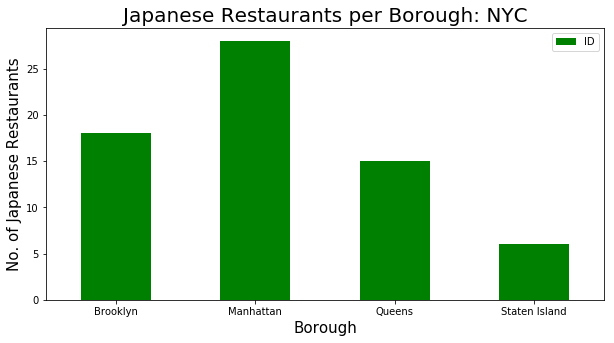

In [13]:
japanese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Japanese Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

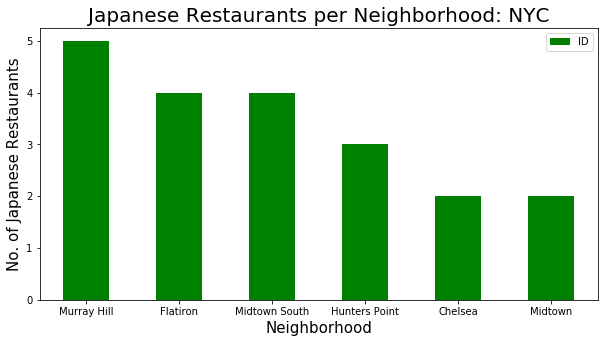

In [14]:
NOofNeigh = 6 # top number for graphing all the same past 6
japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Japanese Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [15]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Murray Hill']

,Borough,Neighborhood,ID,Name
20,Manhattan,Murray Hill,4a99b4f4f964a520f62f20e3,Kajitsu
21,Manhattan,Murray Hill,559cbaa6498eaa4e8d884811,Tempura Matsui
22,Manhattan,Murray Hill,591caee89deb7d0f69be77a2,Omusubi Gonbei
23,Manhattan,Murray Hill,540dc46d498e86f0e5059dd2,Zuma New York
38,Queens,Murray Hill,4bc8eee83740b713fcbe5d65,Northern Sushi


So the Murray Hill in Manhattan has the highest number of Japanese Restaurants with a total count of 5.

Now we will get the ranking of each restaurant for further analysis.

In [16]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in japanese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(japanese_rest_ny),')','processed')
    japanese_rest_stats_ny = japanese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

{'meta': {'code': 200, 'requestId': '5fcaf848e9db494cf4da393f'}, 'response': {'venue': {'id': '4d5c12a01e43236a87eb1583', 'name': 'Sake Sushi', 'contact': {'phone': '7188515299', 'formattedPhone': '(718) 851-5299'}, 'location': {'address': '328 Church Ave', 'crossStreet': 'East 4th Street', 'lat': 40.644138, 'lng': -73.976439, 'labeledLatLngs': [{'label': 'display', 'lat': 40.644138, 'lng': -73.976439}], 'postalCode': '11218', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['328 Church Ave (East 4th Street)', 'Brooklyn, NY 11218', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sake-sushi/4d5c12a01e43236a87eb1583', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 49}, 'url': 'http

KeyError: 'venue'

In [17]:
japanese_rest_stats_ny.to_csv('japanese_rest_stats_ny_csv.csv') # As I move through this project I continue to save data to a .csv file


In [18]:
japanese_rest_stats_ny.shape


(50, 7)

We got statistics for all 50 Japanese Restaurants in New York city.

Let's check what values we have in our DataFrame

In [19]:
japanese_rest_stats_ny.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null object
Rating          50 non-null float64
Tips            50 non-null object
dtypes: float64(1), object(6)
memory usage: 2.8+ KB


We see that the values like Likes, Tips are string values. We would need to convert them into float for further analysis



In [20]:
japanese_rest_stats_ny['Likes'] = japanese_rest_stats_ny['Likes'].astype('float64')
japanese_rest_stats_ny['Tips'] = japanese_rest_stats_ny['Tips'].astype('float64')
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null float64
Rating          50 non-null float64
Tips            50 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.8+ KB


Now when the data types look correct, let's continue our analysis.¶


In [21]:

japanese_rest_stats_ny.describe()

,Likes,Rating,Tips
count,50.000000,50.000000,50.000000
mean,140.460000,7.584000,44.080000
std,237.823825,2.065495,72.670585
min,0.000000,0.000000,0.000000
25%,14.250000,7.500000,6.000000
50%,44.000000,8.200000,13.500000
75%,130.500000,8.675000,48.250000
max,1053.000000,9.300000,353.000000


In [22]:
# Resturant with maximum Likes
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood               Midtown South
ID              51e8ce40498ea1fb0180efb2
Name                         Izakaya MEW
Likes                               1053
Rating                               8.9
Tips                                 265
Name: 49, dtype: object

In [23]:

# Resturant with maximum Ratings
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                East Village
ID              510c85e7e4b0056826b88297
Name                                Kura
Likes                                214
Rating                               9.3
Tips                                  63
Name: 26, dtype: object

In [24]:
# Resturant with maximum Tips
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              454f7cc4f964a520dc3c1fe3
Name                            Morimoto
Likes                                791
Rating                               8.9
Tips                                 353
Name: 25, dtype: object

## Now let's identify and visualize neighborhood with the maximum average rating of restaurants¶


ny_neighborhood_stats=japanese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

In [26]:
ny_borough_stats=japanese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
0,Brooklyn,8.335714
1,Manhattan,8.315000
2,Queens,6.030000
3,Staten Island,5.983333



Similarly these are the average ratings of Japanese Restaurants for each Borough

## Let's visualize the results

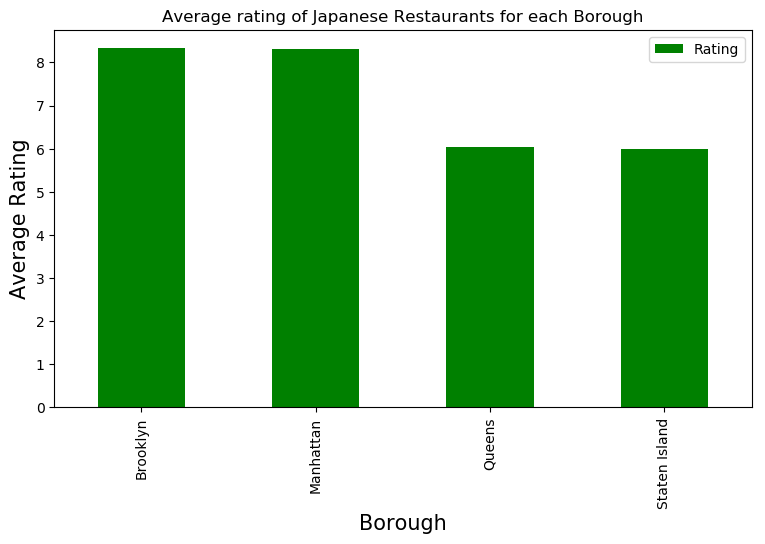

In [27]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Japanese Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
japanese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

We will consider all the neighborhoods with average rating greater or equal 8.0 to visualize on a map


In [29]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Bedford Stuyvesant,8.30
1,Boerum Hill,8.80
2,Brooklyn Heights,8.20
5,Chelsea,8.80
7,Cobble Hill,9.10
8,Downtown,8.80
9,East Village,9.30
11,Fort Greene,8.70
20,Lenox Hill,8.40
21,Lindenwood,8.80


We will join this Dataset to original New York data to get longitude and latitude

In [30]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,8.30
1,Brooklyn,Boerum Hill,40.685683,-73.983748,8.80
2,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.20
3,Manhattan,Chelsea,40.744035,-74.003116,8.80
4,Staten Island,Chelsea,40.594726,-74.189560,8.80
5,Brooklyn,Cobble Hill,40.687920,-73.998561,9.10
6,Brooklyn,Downtown,40.690844,-73.983463,8.80
7,Manhattan,East Village,40.727847,-73.982226,9.30
8,Brooklyn,Fort Greene,40.688527,-73.972906,8.70
9,Manhattan,Lenox Hill,40.768113,-73.958860,8.40


Now we will show this data on a map



In [31]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Let's add a new field to dataframe for labeling purpose



In [32]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)


## Results / Conclusion
 Brooklyn and Manhattan have the best rated Japanese restaurants on average. Staten Island and The Bronx have the least amount of Japanese restaurants per borough. However, of note, Murray Hill in Manhattan has the highest number of Japanese Restaurants in all of NY. Despite Manhattan having the least number of neighborhoods in all five boroughs, it has the most number of Japanese restaurants. Based on the above information, I would state that Manhattan and Brooklyn are the best locations for Japanese cuisine in NYC. To have the best shot of success, I would open a Japanese restaurant in Brooklyn. Brooklyn has multiple neighborhoods with average ratings exceeding 8.0 on a scale of 1.0 to 10.0 and has less amount of Japanese restaurants than Manhattan, making competition easier. Also we should keep in mind, that real estate prices in Brooklyn are much cheaper than in Manhattan. Finally, I would go to OOTOYA in Manhattan for the best Japanese food based on 1213 likes. As a final note, all of the above analysis is depended on the accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.